# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 7: Fairness and Bias


**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2pt">

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text

HTML(styles)

### Import Libraries

In [2]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, roc_auc_score
)                           
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients for degree-5 polynomial model" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

<a id="contents"></a>

## Notebook contents

- [**Required reading and data description**](#intro)


- [**Question 1: Data exploration [26 pts]**](#part1)
  - [Solutions](#part1solutions)


- [**Question 2: Baseline modeling [21 pts]**](#part2)
  - [Solutions](#part2solutions)


- [**Question 3: Predicting without using `race` [19 pts]**](#part3)
  - [Solutions](#part3solutions)


- [**Question 4: Classification thresholds and fairness [34 pts]**](#part4)
  - [Solutions](#part4solutions)

<a id="intro"></a>

## Required reading and data description

[Return to contents](#contents)

### Required reading

The required readings for this homework are two articles that report on the effectiveness of and issues surrounding the COMPAS recidivism algorithm used in U.S. courts. One article is published by ProPublica and the other by the MIT Technology Review:

1. Angwin, Julia; Larson, Jeff; Mattu, Surya; Kirchner, Lauren (2016). "Machine Bias: There’s software used across the country to predict future criminals. And it’s biased against blacks." ProPublica, May 23, 2016. https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


2. Hao, Karen; Stray, Jonathan (2019). "Can you make AI fairer than a judge? Play our courtroom algorithm game: The US criminal legal system uses predictive algorithms to try to make the judicial process less biased. But there’s a deeper problem." MIT Technology Review, October 17, 2019. https://www.technologyreview.com/2019/10/17/75285/ai-fairer-than-judge-criminal-risk-assessment-algorithm/

You will need to read these articles for the sufficient background needed to successfully complete this homework assignment. It may also be useful to refer back to content covered during the mid-semester lecture on ethics: [Lecture 13: EthiCS](https://edstem.org/us/courses/9045/lessons/23452/slides/138052).

### Data description

In this assignment, we will be analyzing a portion of the data set used by ProPublica in their report. The data are found in the `compas.csv` file and the "data dictionary", which very briefly explains each variable in the data set, can be found in the `compas_datadict.csv` file.

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration [26 pts]</div> 
    
[Return to contents](#contents)

**1.1** What is the statistical objective of the COMPAS algorithm?  How is recidivism prediction used in courtrooms?

**1.2** Consider the information in the provided `compas_datadict.csv`.  Which variables are raw data?  Which are pre-processed data?  Which is the target variable of the COMPAS algorithm?  Which are output(s) of the COMPAS algorithm?   Which should not be used in building our own model to predict recidivism?  

**1.3** Read-in the data and split it into 80% training and 20% test **stratified by `race`** (use `random_state=50`). Before splitting, you may want to process the categorical predictors `c_charge_degree`, `race`, and `sex` first so you don't have to do it separately in train and test later.

**1.4** Now we will do a little EDA. Provide visuals to explore which **unprocessed** quantitative variables, including `decile_score` (**not** the derived binary variables or pre-processed versions of the available quantitative variables, for example), are related to `race`.

**HINT:** You may find your Question 1.4 visuals to be more legible and Question 1.5 easier to answer by grouping your non-Caucasion and non-African-American observations together as "all other" racial groups in your plots. However, if you choose to do so, this should only be a temporary grouping of those observations for plotting purposes. Your actual observations should NOT be grouped.

**1.5** Based on your visuals, report which 3 variables appear to have the most significant differences between Caucasians and African Americans. Briefly interpret your findings for each of those 3 variables, being certain to explain your justification for choosing each.

**NOTE:** As illustrated by [the required readings](#intro), reporting on the U.S. Criminal Justice system often concentrates on the disparate experiences between Caucasians and African Americans, thus we have focused our approaches similarly. However, to ensure the efficacy of our models in Question 2 and Question 3, we must be certain to still keep observations for all racial groups included in our data. 

**1.6** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?

<a id="part1solutions"></a>

## Question 1: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**1.1** What is the statistical objective of the COMPAS algorithm?  How is recidivism prediction used in courtrooms?

</div>

* The COMPAS algorthim creator wanted a tool that addressed the major theories about the causes of crime and use the results primarily to determine which defendants are eligible for probation or treatment programs - their focus was on reducing crime rather than punishment. The algorithm aims to help assess “criminogenic needs” that relate to the major theories of criminality, including “criminal personality,” “social isolation,” “substance abuse” and “residence/stability.” 

    * The algorithm trains on data of previous defendants and tries to find a correlation between the predictors like someone's age and criminal history and whether or not the person was rearrested. It then uses the correlations to predict the likelihood that a defendant will be arrested for a new crime during the trial-waiting period. 

    * Unfortunatley, the judges tend to use the algorithm to give longer sentences to defendants with higher risk scores and it has been noticed that judges have cited scores in their sentencing decisions.



* The aim of the COMPAS algorithm was at first to determine whether a defendant would be eligible for treatment programs or probation. However its objective isn't met by its usage in courtrooms. Courtrooms use this algorithm as a score to base they sentence decision, rather than part of the assessment of the trial. 

* The statistical objective of the COMPAS algorithm is to predict recidivism (within 2 years)/how risky the person can be to society, but not to be used as a measure for the length of sentencing. Contrarily to its objective, the usage in courtroom of the COMPAS algorithm is that: if somone has a low preicted chance of recidivism, their sentence will be smaller; if they are predicted with higher changes of recidivism, their sentence will be longer. 



<div class='exercise-r'>

**1.2** Consider the information in the provided `compas_datadict.csv`.  Which variables are raw data?  Which are pre-processed data?  Which is the target variable of the COMPAS algorithm?  Which are output(s) of the COMPAS algorithm?   Which should not be used in building our own model to predict recidivism?

</div>

In [3]:
pd.set_option('display.max_colwidth', None)
datadict = pd.read_csv("data/compas_datadict.csv")
datadict

,Variable,Description
0,age,Defendant's age in years
1,c_charge_degree,"The type of crime a defendant has been charged with, either M (misdemeanor, less serious) or F (felony, more serious)"
2,race,Defendant's race (categorical)
3,sex,Defendant's biological sex (Male/Female)
4,length_of_stay,How long between when a defendant was charged and when they were released. Often determined by a judge's decision of whether the defendant is at risk of recidivating.
5,length_of_stay_thresh,"Thresholded version of length_of_stay variable, where values above 30 have been capped at 30"
6,priors_count,Count for number of prior times a defendant has been charged
7,priors_1,"Indicator variable derived from priors_count, 1 if priors_count=1, 0 otherwise"
8,priors_234,"Indicator variable derived from priors_count, 1 if priors_count is 2, 3, 4; 0 otherwise"
9,priors_5plus,"Indicator variable derived from priors_count, 1 if priors_count=5 or more, 0 otherwise"


Raw:

* age
* c_charge_degree
* race
* sex
* length_of_stay
* priors_count
* juv_fel_count
* juv_misd_count
* juv_other_count
* c_charge_desc
* two_year_recid

Pre-preprocesseed: 

* lenght_of_stay_thresh
* priors_1
* priors_234
* priors_5plus
* juv_fel_1plus
* juv_misd_1plus
* juv_other_1plus
* charge_any_drug
* charge_any_violence_aggression
* charge_any_theft
* score_tesxt 
* decile_score 

**Which is the target variable of the COMPAS algorithm?  Which are output(s) of the COMPAS algorithm?   Which should not be used in building our own model to predict recidivism?**

Target variabe: `two_year_recid`

Which are the outputs of the COMPAS algorithm: `score_text`, `decile_score`

Which should not be used in building the model to predict recidivism: `two_year_recid`, `race`, `sex`, `age`. `race`,  `age`, `sex`, `score_text`, `decile_score` should not be used because they are protected classes in the United States.




<div class='exercise-r'>

**1.3** Read-in the data and split it into 80% training and 20% test **stratified by `race`** (use `random_state=50`). Before splitting, you may want to process the categorical predictors `c_charge_degree`, `race`, and `sex` first so you don't have to do it separately in train and test later.

</div>

**Creating dummy variables for race, sex and c_charge_degree:**

In [4]:
data = pd.read_csv('./data/compas.csv')

# Male = 1, Female = 0
sex = (data['sex'] == 'Male').astype(int)
data.insert(6,'sex_int', sex)
race_list = data.race.unique()

# Misdemeanor = 1, Felony = 0
charge_int = (data['c_charge_degree'] == "M").astype(int)
data.insert(2,'charge_int', charge_int)

# Use dummy variables for race, but then drop one! I will either drop or not use Other
dummy_race = pd.get_dummies(data['race'], drop_first = False)
data = data.join(dummy_race)
data.head()

,age,c_charge_degree,charge_int,c_charge_desc,race,score_text,sex,sex_int,priors_count,juv_fel_count,...,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh,African-American,Asian,Caucasian,Hispanic,Native American,Other
0,69,F,0,Aggravated Assault w/Firearm,Other,Low,Male,1,0,0,...,0,1,0,1,0,0,0,0,0,1
1,34,F,0,Felony Battery w/Prior Convict,African-American,Low,Male,1,0,0,...,0,1,0,10,1,0,0,0,0,0
2,24,F,0,Possession of Cocaine,African-American,Low,Male,1,4,0,...,1,0,0,1,1,0,0,0,0,0
3,44,M,1,Battery,Other,Low,Male,1,0,0,...,0,1,0,1,0,0,0,0,0,1
4,41,F,0,Possession Burglary Tools,Caucasian,Medium,Male,1,14,0,...,0,0,1,6,0,0,1,0,0,0


**Stratified train-test split for Race:**

In [5]:
X = data.drop(['two_year_recid'],axis=1)
y = data['two_year_recid']
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=50, stratify=data["race"])

<div class='exercise-r'>

**1.4** Now we will do a little EDA. Provide visuals to explore which **unprocessed** quantitative variables, including `decile_score` (**not** the derived binary variables or pre-processed versions of the available quantitative variables, for example), are related to `race`.

**HINT:** You may find your Question 1.4 visuals to be more legible and Question 1.5 easier to answer by grouping your non-Caucasion and non-African-American observations together as "all other" racial groups in your plots. However, if you choose to do so, this should only be a temporary grouping of those observations for plotting purposes. Your actual observations should NOT be grouped.

</div>

In [6]:
###### Unprocessed variables 
unprocessed = ['age', 'sex', 'race', 'length_of_stay', 'priors_count', 'juv_other_count', 'c_charge_degree', 
'c_charge_desc', 'juv_fel_count', 'juv_misd_count', 'decile_score'] 


###### Quantitative variables that were unprocessed
unprocessed = ['age', 'length_of_stay', 'priors_count', 'juv_other_count', 'juv_fel_count',
               'juv_misd_count', 'decile_score']  

# Here I am grouping everyone that is not African American and Caucasian into an 'other_group' masking.
# Here I do NOT use the column other, because Other comes from the dummyfication of Race, 
# We need number of dummies = number of categories -1
# Hence, one needs not to be considered, to avoid collinearity I decide not to consider Other

African_Am = data['African-American'] == 1
white = data['Caucasian'] == 1
other_group =(data['African-American'] != 1) & (data['Caucasian']!=1) & (data['Other']!=1)


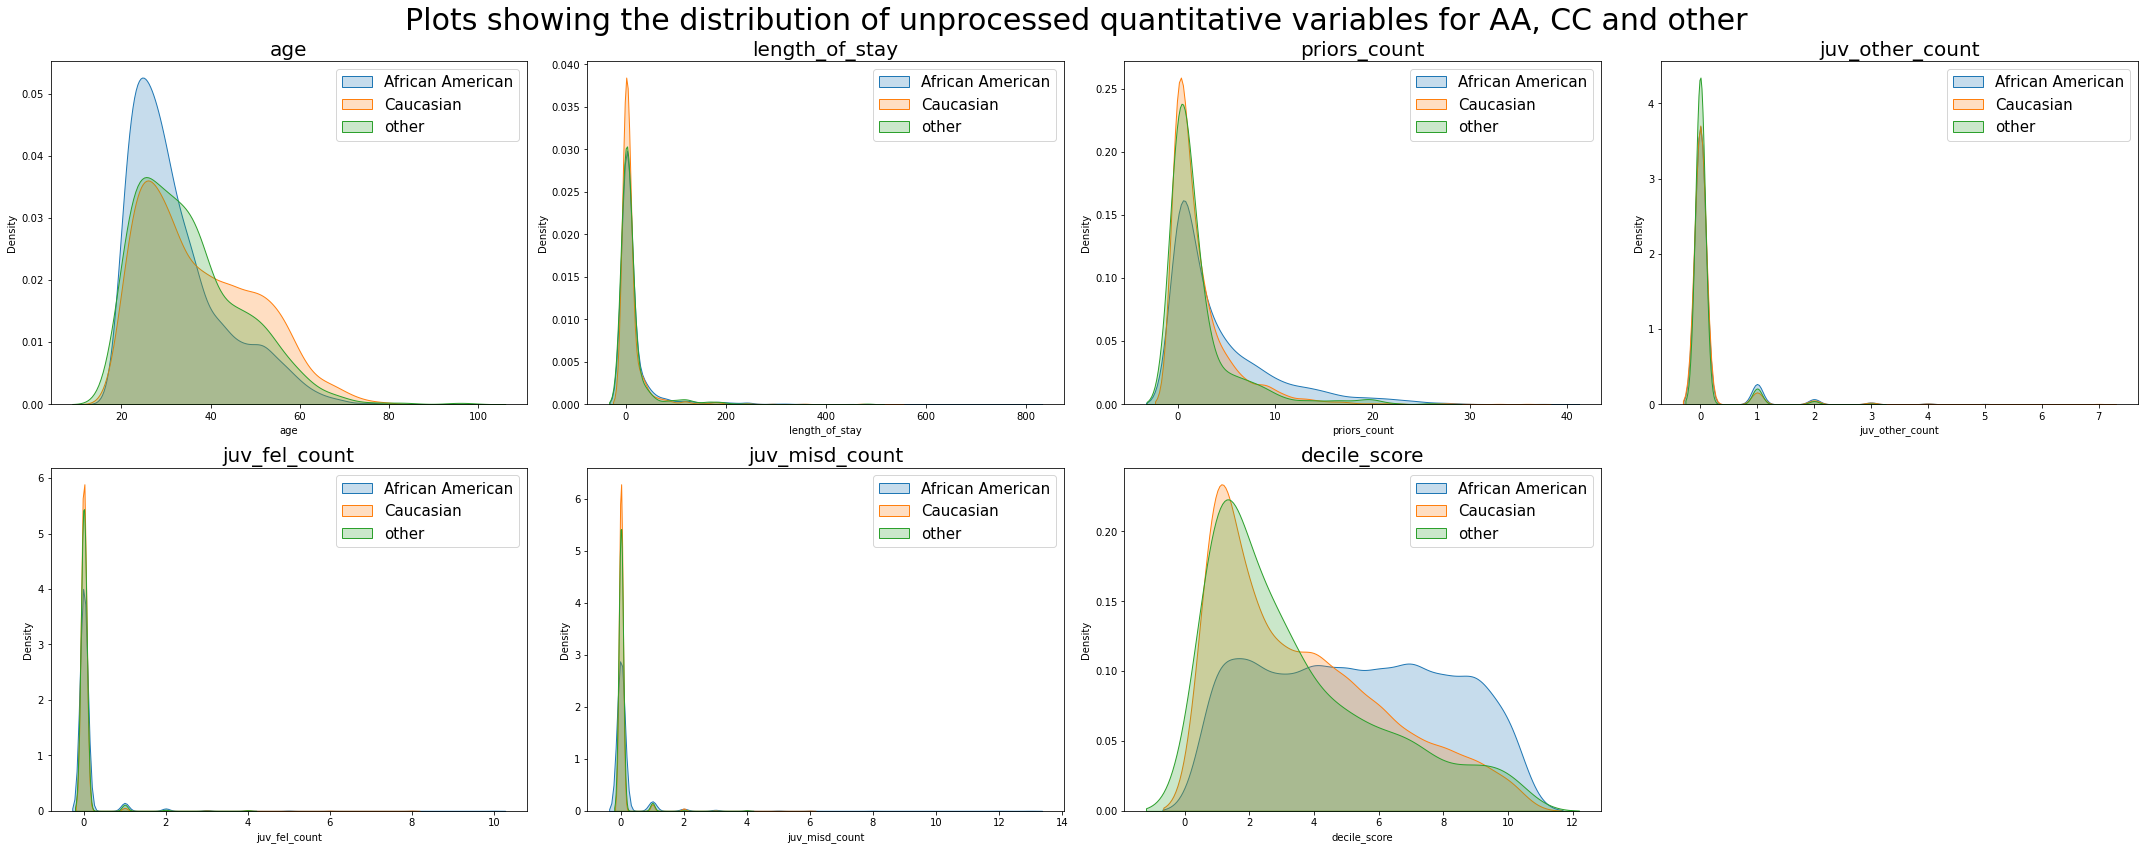

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(30,12))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
plt.suptitle("Plots showing the distribution of unprocessed quantitative variables for AA, CC and other", size = 30)
axes = axes.flatten()
for i, j  in enumerate(unprocessed):
    axes[i].set_title(f"{j}", size = 20)
    sns.kdeplot(data=data[African_Am], x =j,ax = axes[i],fill = True, legend ="African american")
    sns.kdeplot(data=data[white], x =j,ax = axes[i],fill = True, legend = "Caucasian")
    sns.kdeplot(data=data[other_group], x =j,ax = axes[i],fill = True, legend = "other")
    axes[i].legend(labels = ['African American', 'Caucasian', 'other'], fontsize =15)
    plt.tight_layout()
fig.delaxes(axes[7])

<div class='exercise-r'>

**1.5** Based on your visuals, report which 3 variables appear to have the most significant differences between Caucasians and African Americans. Briefly interpret your findings for each of those 3 variables, being certain to explain your justification for choosing each.

**NOTE:** As illustrated by [the required readings](#intro), reporting on the U.S. Criminal Justice system often concentrates on the disparate experiences between Caucasians and African Americans, thus we have focused our approaches similarly. However, to ensure the efficacy of our models in Question 2 and Question 3, we must be certain to still keep observations for all racial groups included in our data. 
</div>



* **Age** : On average, African Americans( AA) that commit crimes (and that are caught) are younger compared to Caucasians( CC) and others that commit crimes and that are caught. Less young CC and other people are caught doing crimes compared to young AA. This is related to people who got caught doing crimes, not about people doing them. This might be related to how racial profiling might be more present within young people of colour compared to profiling of white people. 

* **Decile score**: On average, AA have worse decile scores compared to CC and other. Meaning that the model COMPAS spits out worse scores for AA compared to CC and other.

* **Priors count** : On average, AA people have larger priors counts being charged of a crime compared to CC and other. 

<div class='exercise-r'>

**1.6** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?

</div>


**Bias in data:**

In the data there is a majority of AA compared to CC - hence the distributions in the graphs above are also influence by how this data was collected.
Additonally, in this dataset it seems that the AA in this dataset have crimes that are worse than the crimes of CC - hence given in how this data was collected, this also influences the distributions above. Furthermore, this data is a sample of somewhere in the US, and not the whole population data - but we do not know if this sample was collected in a representative way enough. 

Furthermore, we have to take into account that the dataset is inherently biased because the american society is biased.
Most likely, in the US the interaction with police is going to be different depending on your ethnicity.
Additionally, the US is a country where it is known that black neighbourhoods have stricter/more policing compared to neighbourhoods with a majority of white inhabitants. 
If the policing is higher in black neighourboods, inherently as a consequence there will be  a higher amount of caught/found crimes.


**Bias in data collection:**

* **Priors count**: there are several ongoing cases and discusions about people of colour being charged unfairly/incorrectly, consequently there is already bias in this piece of data inherently. 

* **Age**: racial profiling on young AA is more common than racial profiling of white yound people. Given this bias in society, it makes this piece of data of having also bias. 

* **Decile score ("Risk score" in the ProRepublica article):** this is a biased variable because decile score is based on some risk parameters (i.e. as answer to a questionnaire that has questions like:“Was one of your parents ever sent to jail or prison?” “How many of your friends/acquaintances are taking drugs illegally?” and “How often did you get in fights while at school?”, see the ProRepublica article) that most often affect black and poorer neighourhoods rather than white neighbourhoods and that are outside of control of the person interviewed, regardless of the crime that they committed or not. 


---

<a id="part2"></a>

## <div class="exercise">Question 2: Baseline modeling [21 pts]</div> 
    
[Return to contents](#contents)

**2.1**  Build a well-tuned $LASSO$-like regularized logistic regression model to predict recidivism (i.e. `two_year_recid` is your response variable). Use the following predictors: `age`, `priors_1`, `priors_234`, `priors_5plus`, `juv_fel_1plus`, `juv_misd_1plus`, `juv_other_1plus`, `charge_any_drug`, `charge_any_violence_aggression`, `charge_any_theft`, as well as your one-hot-encoded predictors for `c_charge_degree`, `sex`, and `race`. Report your resulting coefficients and interpret what this model is saying about the relationship of `two_year_recid` to `race`.


**2.2**  Report the following on the **test set**:

1. **Overall model accuracy score**


2. **False positive rates (FPR)** for each of the two groups (please note that a "positive" here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
    
    
3. **False negative rates (FNR)** for each of the two groups:
    - `African-American`
    - `Caucasian`


4. **Ratios of error rates**:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups
    - These ratios can be expressed as:

$$\frac{FPR(AA)}{FPR(CC)} \; \text{and} \; \frac{FNR(AA)}{FNR(CC)}$$


**2.3**  What do you observe? Is there any disparity in the $FPR$ and $FNR$ for the two groups? What are the implications of your findings? Explain your findings in 3-6 sentences.
    
  

<a id="part2solutions"></a>

## Question 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1**  Build a well-tuned $LASSO$-like regularized logistic regression model to predict recidivism (i.e. `two_year_recid` is your response variable). Use the following predictors: `age`, `priors_1`, `priors_234`, `priors_5plus`, `juv_fel_1plus`, `juv_misd_1plus`, `juv_other_1plus`, `charge_any_drug`, `charge_any_violence_aggression`, `charge_any_theft`, as well as your one-hot-encoded predictors for `c_charge_degree`, `sex`, and `race`. Report your resulting coefficients and interpret what this model is saying about the relationship of `two_year_recid` to `race`.

</div>

In [8]:

predictors = ['age', 'priors_1', 'priors_234','priors_5plus', 'juv_fel_1plus', 'juv_misd_1plus', 'juv_other_1plus', 
'charge_any_drug', 'charge_any_violence_aggression', 'charge_any_theft','sex_int','charge_int','African-American', 
'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']
response = 'two_year_recid'

In [9]:

x_train = x_train[predictors]
x_test = x_test[predictors]

non_binary_predict = ['age']
scaler = MinMaxScaler().fit(x_train[non_binary_predict])
x_train[non_binary_predict] = scaler.transform(x_train[non_binary_predict])
x_test[non_binary_predict] = scaler.transform(x_test[non_binary_predict])

In [10]:
x_test.drop(columns=['Other'])
x_train.drop(columns=['Other'])

predictors_list = x_test.columns.values.tolist()

In [11]:

lr2_1 = LogisticRegressionCV(penalty = 'l1', solver = 'liblinear', max_iter =2500, random_state = 50)
xtrain_lasso = x_train
xtest_lasso = x_test

lr2_1.fit(xtrain_lasso, y_train)
y_pred = lr2_1.predict(xtest_lasso)

coef = lr2_1.coef_[0]
intercept = lr2_1.intercept_[0]

print("---------Coefficients--------------")
for i in range(len(predictors_list)):
    print(predictors_list[i], ":", round(coef[i],3))

print('intercept:', round(intercept,3))

---------Coefficients--------------
age : -2.19
priors_1 : 0.012
priors_234 : 0.544
priors_5plus : 1.346
juv_fel_1plus : 0.0
juv_misd_1plus : 0.0
juv_other_1plus : 0.423
charge_any_drug : 0.071
charge_any_violence_aggression : 0.0
charge_any_theft : 0.099
sex_int : 0.053
charge_int : -0.199
African-American : 0.116
Asian : 0.0
Caucasian : 0.0
Hispanic : 0.0
Native American : 0.0
Other : 0.0
intercept: -0.248


**INTERPRETATION:**



This model says that if the person is AA this person is more likely to commit a crime within the next 2 years, compared to a non AA. This is the case because the coefficient for AA is positive, and the coefficient for all other race variables is 0. 

Meaning that the likelihood of the `two_year_recid`  variable to be 1 is more likely if the variable `African-American` is equal to 1. 

<div class='exercise-r'>

**2.2**  Report the following on the **test set**:

1. **Overall model accuracy score**


2. **False positive rates (FPR)** for each of the two groups (please note that a "positive" here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
    
    
3. **False negative rates (FNR)** for each of the two groups:
    - `African-American`
    - `Caucasian`


4. **Ratios of error rates**:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups
    - These ratios can be expressed as:

$$\frac{FPR(AA)}{FPR(CC)} \; \text{and} \; \frac{FNR(AA)}{FNR(CC)}$$

</div>

**1. Overall model accuracy score:**

In [12]:
print(f"Overall model accuracy score: {lr2_1.score(xtest_lasso, y_test):.4f}")

Overall model accuracy score: 0.6688


In [13]:
mask_cc = (x_test['Caucasian'] ==1).values
mask_aa = (x_test['African-American'] == 1).values

y_pred_cc = y_pred[mask_cc]
y_pred_aa = y_pred[mask_aa]

y_test_cc = y_test[mask_cc]
y_test_aa = y_test[mask_aa]

tn, fp, fn, tp = confusion_matrix(y_test_aa, y_pred_aa).ravel()

FPR_aa = fp/ (fp + tn)
FNR_aa = fn / (tp + fn)

tn, fp, fn, tp = confusion_matrix(y_test_cc, y_pred_cc).ravel()

FPR_cc = fp/ (fp + tn)
FNR_cc = fn / (tp + fn)


**2. False positive rates (FPR) for the two groups:**

In [14]:
print(f"False Positive Rate Afro American:  {FPR_aa:.4f}")
print(f"False Positive Rate Caucasian:  {FPR_cc:.4f}")

False Positive Rate Afro American:  0.3301
False Positive Rate Caucasian:  0.1751


**3. False negative rates (FNR) for the two groups:**

In [15]:
print(f"False Negative Rate Afro American:  {FNR_aa:.4f}")
print(f"False Negative Rate Caucasian: {FNR_cc:.4f}")

False Negative Rate Afro American:  0.3436
False Negative Rate Caucasian: 0.5366


**4. Ratio of error rates:**

In [16]:
print("Ratio of error rates:")

FPR_ratio = FPR_aa/FPR_cc
FNR_ratio = FNR_aa/FNR_cc

print("--------")
print(f"FPR_aa/FPR_cc :  {FPR_ratio:.4f}")
print(f"FNR_aa/FNR_cc :  {FNR_ratio:.4f}")

Ratio of error rates:
--------
FPR_aa/FPR_cc :  1.8852
FNR_aa/FNR_cc :  0.6403


<div class='exercise-r'>

**2.3**  What do you observe? Is there any disparity in the $FPR$ and $FNR$ for the two groups? What are the implications of your findings? Explain your findings in 3-6 sentences.

</div>

* **False positive**: in this context, this means that someone is being holded, when they actually should be free.
    * false positive: keeping people in jail when they should be free

    * this is a mistake. **If the ratio of this mistake is high (i.e. above 1)**, it means that this mistake is being done more frequently with AA compared to CC. Meaning that more AA are charged when they should actually be not charged. If this ratio is bigger than one, this is a signal that there is a strong evidence of a form of bias here. 
    * This is the case here, with 1.8852 as ratio of FP rates between AA and CC. 


* **False negative**: in this context, this means that somone is being released, when actually they should be in jail.  

    * false negative: letting someone free who should be in jail, 
    * this is a mistake. **If the ratio of this mistake is low (i.e. below 1)**, it means that you are doing this mistake more frequently with CC compared to AA. Meaning that you are more frequently letting CC free (when they should be charged), compared to AA. If this ratio is low, this is a signal for a form of bias. 
    * This is here the case, as the ratio is 0.6403.



---

<a id="part3"></a>

## <div class='exercise'>Question 3: Predicting without using `race` [19 pts]</div> 
    
[Return to contents](#contents)

**3.1** Fit another well-tuned $LASSO$-like regularized logistic regression model just as you did in Question 2.1, but this time **without** `race` as a predictor. Report your resulting coefficients.

**3.2** Again, report the following on the **test set**:

1. **Overall model accuracy score**


2. **False positive rates (FPR)** for each of the two groups (please note that a "positive" here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
    
    
3. **False negative rates (FNR)** for each of the two groups:
    - `African-American`
    - `Caucasian`


4. **Ratios of error rates**:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups
    - These ratios can be expressed as:

$$\frac{FPR(AA)}{FPR(CC)} \; \text{and} \; \frac{FNR(AA)}{FNR(CC)}$$


**3.3**  How do these metrics compare to the model when the variable `race` **is** included as a predictor?

**3.4**  Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not? Give careful consideration to why the bias is still occurring or not still occurring in your results and what the real-life implications/effects might be for such a tool.

<a id="part3solutions"></a>

## Question 3: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**3.1** Fit another well-tuned $LASSO$-like regularized logistic regression model just as you did in Question 2.1, but this time **without** `race` as a predictor. Report your resulting coefficients.

</div>

In [17]:

race_cols =list(dummy_race.columns)
predictors = ['age', 'priors_1', 'priors_234','priors_5plus', 'juv_fel_1plus', 'juv_misd_1plus', 'juv_other_1plus', 
'charge_any_drug', 'charge_any_violence_aggression', 'charge_any_theft','sex_int','charge_int' ] 

lr3_1 = LogisticRegressionCV(penalty = 'l1', solver = 'liblinear', max_iter =1000, random_state= 50)
xtrain_lasso = x_train[predictors]
xtest_lasso = x_test[predictors]

lr3_1.fit(xtrain_lasso, y_train)
y_pred3_1 = lr3_1.predict(xtest_lasso)

coef = lr3_1.coef_[0]
intercept = lr3_1.intercept_[0]

print("---------Coefficients--------------")

for i in range(len(predictors)):
    print(predictors[i], ":", round(coef[i],3))

print('intercept:', round(intercept,3))

---------Coefficients--------------
age : -3.003
priors_1 : 0.376
priors_234 : 0.897
priors_5plus : 1.749
juv_fel_1plus : 0.046
juv_misd_1plus : 0.138
juv_other_1plus : 0.563
charge_any_drug : 0.312
charge_any_violence_aggression : 0.15
charge_any_theft : 0.386
sex_int : 0.26
charge_int : -0.161
intercept: -0.628


<div class='exercise-r'>

**3.2** Again, report the following on the **test set**:

1. **Overall model accuracy score**


2. **False positive rates (FPR)** for each of the two groups (please note that a "positive" here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
    
    
3. **False negative rates (FNR)** for each of the two groups:
    - `African-American`
    - `Caucasian`


4. **Ratios of error rates**:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups
    - These ratios can be expressed as:

$$\frac{FPR(AA)}{FPR(CC)} \; \text{and} \; \frac{FNR(AA)}{FNR(CC)}$$

</div>

**1. Overall model accuracy score:**

In [18]:
print(f"Overall model accuracy score: {lr3_1.score(xtest_lasso, y_test)}")

Overall model accuracy score: 0.682591093117409


In [19]:
mask_cc = (x_test['Caucasian'] ==1).values
mask_aa = (x_test['African-American'] == 1).values

y_pred_cc = y_pred3_1[mask_cc]
y_pred_aa = y_pred3_1[mask_aa]

y_test_cc = y_test[mask_cc]
y_test_aa = y_test[mask_aa]


tn, fp, fn, tp = confusion_matrix(y_test_aa, y_pred_aa).ravel()
FPR_aa = fp/ (fp + tn)
FNR_aa = fn / (tp + fn)

tn, fp, fn, tp = confusion_matrix(y_test_cc, y_pred_cc).ravel()
FPR_cc = fp/ (fp + tn)
FNR_cc = fn / (tp + fn)

**2. False positive rates (FPR) for the two groups:**

In [20]:
print(f"False Positive Rate Afro American:  {FPR_aa:.4f}")
print(f"False Positive Rate Cucasian:  {FPR_cc:.4f}")

False Positive Rate Afro American:  0.3333
False Positive Rate Cucasian:  0.2101


**3. False negative rates (FNR) for the two groups:**

In [21]:
print(f"False Negative Rate Afro American:  {FNR_aa:.4f}")
print(f"False Negative Rate Caucasian: {FNR_cc:.4f}")

False Negative Rate Afro American:  0.3037
False Negative Rate Caucasian: 0.4756


**4. Ratio of error rates:**

In [22]:
print("Ratio of error rates:")

FPR_ratio = FPR_aa/FPR_cc
FNR_ratio = FNR_aa/FNR_cc

print("--------")
print(f"FPR_aa/FPR_cc :  {FPR_ratio:.4f}")
print(f"FNR_aa/FNR_cc :  {FNR_ratio:.4f}")

Ratio of error rates:
--------
FPR_aa/FPR_cc :  1.5864
FNR_aa/FNR_cc :  0.6385


<div class='exercise-r'>

**3.3**  How do these metrics compare to the model when the variable `race` **is** included as a predictor?

</div>

* **FPR ratio between AA and CC**: compared to 2.2, the FPR ratio between African American (AA) and caucasian (CC) is here lower, meaning that there is a slight improvement. 
    * The slight improvement is from 1.88 yo 1.58.
    * here the bias has been lowered
* **FNR ratio between AA and CC**: compared to 2.2, the FNR ratio between African American (AA) and caucasian (CC) is here slightly smaller, meaning that there is a slight worsening.
    * The slight worsening is from 0.64 to 0.6385.
    * here the bias has been increased slightly
    

There are many other variables that have a lot of correlation with race, so it still inherits a lot of bias though inderectly. 

Hence although we have less bias (FPR ratio lower), there is still bias because of the other variables that are correlated with race, despite the fact that we formally removed raace. 

There is an improvement/reducement of bias only because we removed the colums of race explicitly, but we actually didn't remove the bias from the entire dataset, the bias is still in the model through the other variables.

<div class='exercise-r'>

**3.4**  Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not? Give careful consideration to why the bias is still occurring or not still occurring in your results and what the real-life implications/effects might be for such a tool.

</div>

**Should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?**

* This model should predict recidicism, and should predict it independently of race. I.e. it should not be influenced by the different race groups. 

    * It seems that this model is very much influenced by the different races, hence probably the variables that they picked were not good indicators for recidivism in the first place. 

* The variables at hand are not best positioned to allow this analysis because there was already implicit bias in picking these variables

    * Consequently, in this context, this predictive tool cannot be trusted to be unbiased, even if it does not explicitly use the variable of race.

* To make a predictive tool to be actually unbiased, a whole new process of data colection and features selection should be done from scratch where focus is put on recidivism, and not race. 



---

<a id="part4"></a>

## <div class='exercise'>Question 4: Classification thresholds and fairness [34 pts]</div> 
    
[Return to contents](#contents)

**4.1** Use the logistic regression model from Question 3.1 and plot the Receiver Operating Characteristic (ROC) curves for two racial groups: `African-American` and `Caucasian` in the **training set**.
    
**4.2** The default threshold used for determining the classification metrics analyzed in Question 2.2 and Question 3.2 was $\hat{p}=0.5$.  Choose a new single threshold for the model from Question 3.1 that will reduce the bias between these two racial groups as measured by the "Ratios of Error Rates" (as defined by the formulas shown in Question 3.2). Be certain to justify your choice and interpet how this threshold choice affects your model results.

**HINT:** There is no one correct answer here. However, to arrive at an answer you can support with an evidence-based justification, you will likely need to inspect the "Ratio of $FPR$", "Ratio of $FNR$", and accuracy trends across varying classification thresholds. There should be no need to refit your model from Question 3.1 to accomplish this task.

**4.3** A second approach to reducing bias is to use different thresholds for the different racial groups to better ensure that the individual groups have similar false positive and false negative rates.  Choose a pair of thresholds (one for the `African-American` group and one for the `Caucasian` group) that improves the group bias (while still taking accuracy into consideration). Be certain to justify your choices and interpet how these threshold choices affect your model results.

**HINT:** To arrive at an answer you can support with an evidence-based justification, you will likely need to inspect $FPR$, $FNR$, and accuracy trends across varying classification thresholds for each group (`African-American` and `Caucasian`) individually. There should be no need to refit your model from Question 3.1 to accomplish this task.

**4.4** Comment on [the fairness](<https://en.wikipedia.org/wiki/Fairness_(machine_learning)>) of the two methods in Question 4.2 and Question 4.3 from two different perspectives: the fairness of each group (called "group fairness") and the fairness for an individual defendant (called "individual fairness"). 

**4.5** Changing the thresholds can *reduce* bias between the two classes, but it can also affect model accuracy. We want our model to be **accurate** but also **fair**.  What can be done to balance these two criteria?  Write down your strategy to overcome this difficulty. Please limit your response to at most 150 words.  
     

<a id="part4solutions"></a>

## Question 4: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**4.1** Use the logistic regression model from Question 3.1 and plot the Receiver Operating Characteristic (ROC) curves for two racial groups: `African-American` and `Caucasian` in the **training set**.

</div>

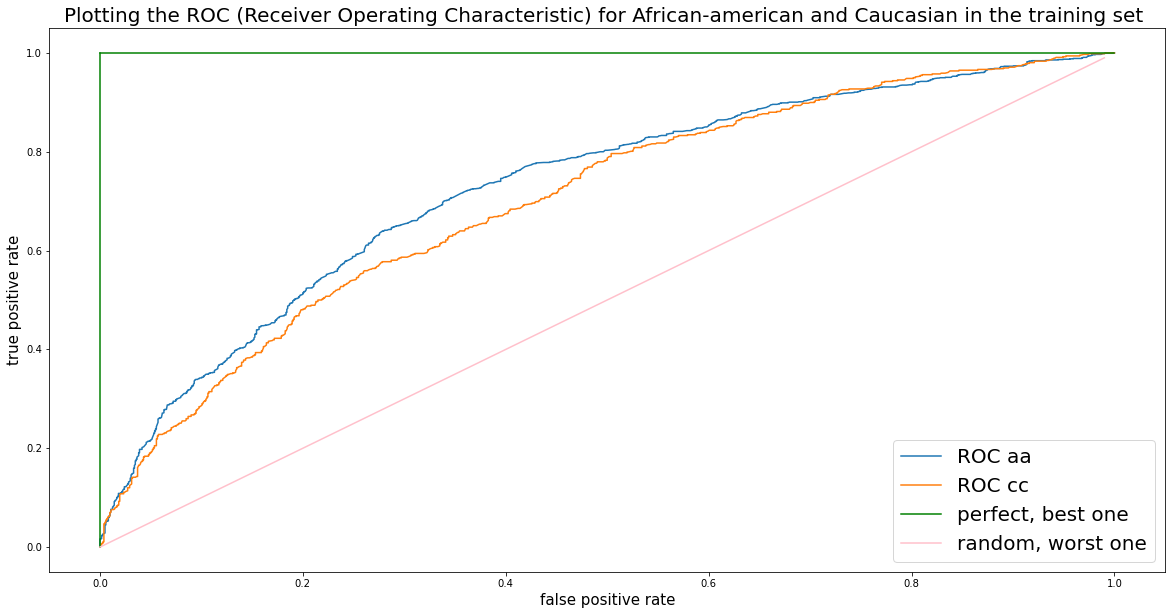

In [23]:
y_pred_train_proba = lr3_1.predict_proba(xtrain_lasso)[:, 1]

mask_cc = (x_train['Caucasian'] ==1).values
mask_aa = (x_train['African-American'] == 1).values

y_pred_train_aa = y_pred_train_proba[mask_aa]
y_pred_train_cc = y_pred_train_proba[mask_cc]

y_train_aa = y_train[mask_aa]
y_train_cc = y_train[mask_cc]

fpr_aa, tpr_aa, threshold_aa = roc_curve(y_train_aa,y_pred_train_aa )
fpr_cc, tpr_cc, threshold_cc = roc_curve(y_train_cc,y_pred_train_cc )


x = np.arange(0,100)/100
plt.figure(figsize = (20, 10))
plt.title('Plotting the ROC (Receiver Operating Characteristic) for African-american and Caucasian in the training set ', size = 20)
plt.plot(fpr_aa, tpr_aa,label = "ROC aa")
plt.plot(fpr_cc, tpr_cc, label = "ROC cc")
plt.xlabel('false positive rate', size = 15)
plt.ylabel('true positive rate', size = 15)
plt.plot([0,0], [0,1], 'g',  label = "perfect, best one")
plt.plot([1,0], [1,1], 'g')
plt.plot(x, x, 'pink', label = "random, worst one" )
plt.plot(label = "perfect, best one")
plt.legend(fontsize = 20)
plt.show()

<div class='exercise-r'>

**4.2** The default threshold used for determining the classification metrics analyzed in Question 2.2 and Question 3.2 was $\hat{p}=0.5$.  Choose a new single threshold for the model from Question 3.1 that will reduce the bias between these two racial groups as measured by the "Ratios of Error Rates" (as defined by the formulas shown in Question 3.2). Be certain to justify your choice and interpet how this threshold choice affects your model results.

**HINT:** There is no one correct answer here. However, to arrive at an answer you can support with an evidence-based justification, you will likely need to inspect the "Ratio of $FPR$", "Ratio of $FNR$", and accuracy trends across varying classification thresholds. There should be no need to refit your model from Question 3.1 to accomplish this task.

</div>

In [24]:

x_lins = np.linspace(0.1, 0.88, 1000)

ratio_list_fp = []
ratio_list_fn = []
accuracies_list = []


for threshold in x_lins:
    y_thr = ((lr3_1.predict_proba(xtrain_lasso)[:, 1])>=threshold).astype(int)
    y_thr_aa = y_thr[mask_aa]
    y_thr_cc = y_thr[mask_cc]

    cc_false_positive = ((y_thr_cc == 1 )&( y_train[mask_cc] == 0 )).sum()
    cc_true_positive = ((y_thr_cc == 1 )&( y_train[mask_cc] == 1 )).sum()


    cc_false_negative = ((y_thr_cc == 0 )&( y_train[mask_cc] == 1 )).sum()
    cc_true_negative = ((y_thr_cc == 0 )&( y_train[mask_cc] == 0 )).sum()


    aa_false_positive = ((y_thr_aa == 1 )&( y_train[mask_aa] == 0 )).sum()
    aa_true_positive = ((y_thr_aa == 1 )&( y_train[mask_aa] == 1 )).sum()


    aa_false_negative = ((y_thr_aa == 0 )&( y_train[mask_aa] == 1 )).sum()
    aa_true_negative = ((y_thr_aa == 0 )&( y_train[mask_aa] == 0 )).sum()
    all_negatives_aa = (y_train[mask_aa] == 0 ).sum()
    all_negatives_cc = (y_train[mask_cc] == 0 ).sum()
    
    all_positives_aa = (y_train[mask_aa] == 1 ).sum()
    all_positives_cc = (y_train[mask_cc] == 1 ).sum()

    FPR_aa = aa_false_positive/(aa_false_positive + aa_true_negative)
    FPR_cc = cc_false_positive/ (cc_false_positive + cc_true_negative)
    
    FNR_aa = aa_false_negative/all_positives_aa
    FNR_cc = cc_false_negative/all_positives_cc


    ratio_fp= FPR_aa/FPR_cc
    ratio_fn= FNR_aa/FNR_cc
    
    ratio_list_fp.append(ratio_fp)
    ratio_list_fn.append(ratio_fn)
    
    acc = ((y_thr == y_train).astype(int)).mean()
    accuracies_list.append(acc)
    

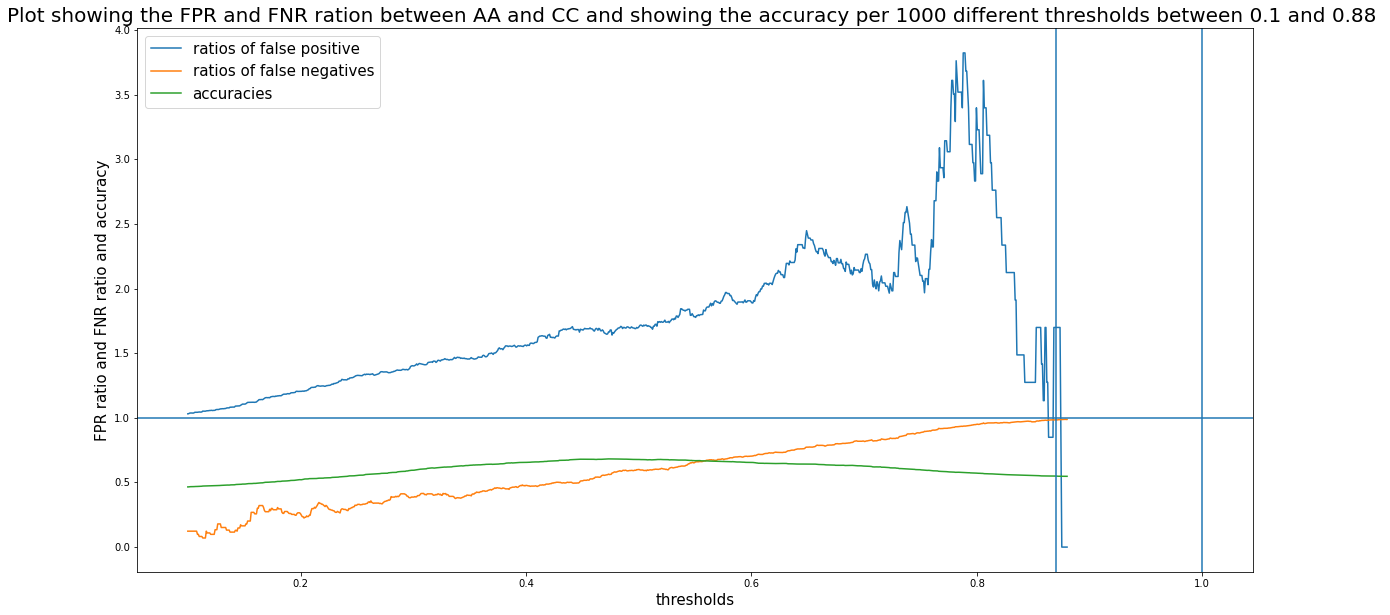

In [25]:
plt.figure(figsize=(20, 10))
plt.title("Plot showing the FPR and FNR ration between AA and CC and showing the accuracy per 1000 different thresholds between 0.1 and 0.88 ", size = 20)
plt.plot(x_lins, ratio_list_fp, label = "ratios of false positive")
plt.plot(x_lins, ratio_list_fn, label = "ratios of false negatives")
plt.plot(x_lins, accuracies_list, label = "accuracies")
plt.axhline(y=1)
plt.axvline(x=1)
plt.axvline(x=0.87)

plt.ylabel("FPR ratio and FNR ratio and accuracy", size = 15)
plt.xlabel(f"thresholds", size = 15)
plt.legend(fontsize = 15)
plt.show()

    

**INTERPRETATION:**




* As seen from the fraph above, there seem to be a **tradeoff**  between the accuracy and the FPR ratio and the FNR ratio. This leads us to three possible scenarios:
    * **1. high accuracy** at the threshold of around 0.5
        * However, the FPR ratio is above one and the FNR ratio is below one. 
    * **2. low accuracy but FPR ratio close to 1** at the threshold of about 0
        * However, there the accuracy is at one of its lowest points, and the FNR ratio is also very close to 0, which is very biased. 
    * **3. low accuracy, but FPR ratio and FNR ratio close to 1** at the threshold of about 0.87
        * Here both FPR nad FNR seem to be close to 1, which is the ideal unbiased scenario. However, this is at the expense of the accuracy, which is very low.
        * My preference, and the threshold that I pick based on my preferences, is the **third scenario**, i.e. the threshold of **0.87**. 
        

* Here, we are picking **1** threshold, of **0.87**
  * This choice is more individual fair, i.e. more fair to the individual compared to the group. This is the case because the same threshold is applied to both groupds (AA and CC).
  * This is less group fair because we are trying to fit a single threshold for the two grops, meaning that this threshold might treat one group less fairly because of that.


<div class='exercise-r'>

**4.3** A second approach to reducing bias is to use different thresholds for the different racial groups to better ensure that the individual groups have similar false positive and false negative rates.  Choose a pair of thresholds (one for the `African-American` group and one for the `Caucasian` group) that improves the group bias (while still taking accuracy into consideration). Be certain to justify your choices and interpet how these threshold choices affect your model results.

**HINT:** To arrive at an answer you can support with an evidence-based justification, you will likely need to inspect $FPR$, $FNR$, and accuracy trends across varying classification thresholds for each group (`African-American` and `Caucasian`) individually. There should be no need to refit your model from Question 3.1 to accomplish this task.

</div>

In [26]:
x_lins = np.linspace(0, 1, 1000)

fp_rate_aa_list = []
fp_rate_cc_list = []


fn_rate_aa_list = []
fn_rate_cc_list = []


accuracies_list = []


for threshold in x_lins:
    y_thr = ((lr3_1.predict_proba(xtrain_lasso)[:, 1])>=threshold).astype(int)
    y_thr_aa = y_thr[mask_aa]
    y_thr_cc = y_thr[mask_cc]

    cc_false_positive = ((y_thr_cc == 1 )&( y_train[mask_cc] == 0 )).sum() 
    cc_true_positive = ((y_thr_cc == 1 )&( y_train[mask_cc] == 1 )).sum()

    cc_false_negative = ((y_thr_cc == 0 )&( y_train[mask_cc] == 1 )).sum()
    cc_true_negative = ((y_thr_cc == 0 )&( y_train[mask_cc] == 0 )).sum()

    aa_false_positive = ((y_thr_aa == 1 )&( y_train[mask_aa] == 0 )).sum()
    aa_true_positive = ((y_thr_aa == 1 )&( y_train[mask_aa] == 1 )).sum()

    aa_false_negative = ((y_thr_aa == 0 )&( y_train[mask_aa] == 1 )).sum()
    aa_true_negative = ((y_thr_aa == 0 )&( y_train[mask_aa] == 0 )).sum()
    

    
    all_negatives_aa = (y_train[mask_aa] == 0 ).sum()
    all_negatives_cc = (y_train[mask_cc] == 0 ).sum()
    
    all_positives_aa = (y_train[mask_aa] == 1 ).sum()
    all_positives_cc = (y_train[mask_cc] == 1 ).sum()
    
    FPR_aa = aa_false_positive/all_negatives_aa
    FPR_cc = cc_false_positive/all_negatives_cc
    
    FNR_aa = aa_false_negative/all_positives_aa
    FNR_cc = cc_false_negative/all_positives_cc
    
    
    fp_rate_aa_list.append(FPR_aa)
    fp_rate_cc_list.append(FPR_cc)


    fn_rate_aa_list.append(FNR_aa)
    fn_rate_cc_list.append(FNR_cc)
    
    classification = (y_thr > threshold).astype(int)
    acc = ((classification == y_train).astype(int)).mean()
    accuracies_list.append(acc)



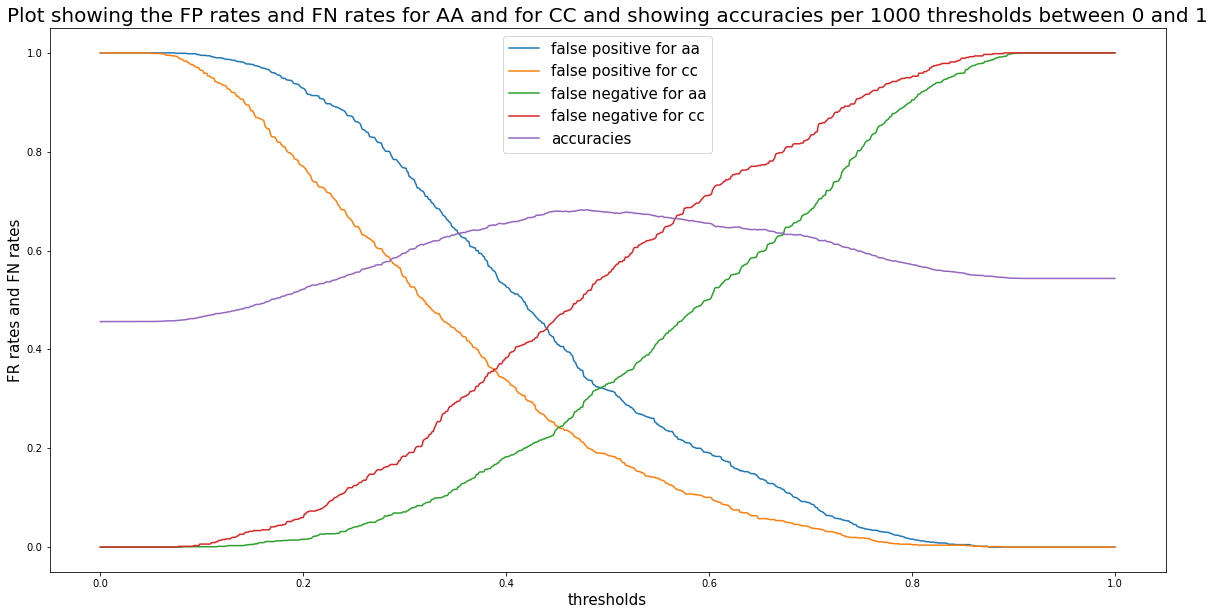

In [27]:
plt.figure(figsize = (20, 10))
plt.title("Plot showing the FP rates and FN rates for AA and for CC and showing accuracies per 1000 thresholds between 0 and 1", size = 20)
plt.plot(x_lins,fp_rate_aa_list, label = "false positive for aa" )
plt.plot(x_lins,fp_rate_cc_list , label = "false positive for cc")
plt.plot(x_lins,fn_rate_aa_list, label = "false negative for aa" )
plt.plot(x_lins,fn_rate_cc_list, label = "false negative for cc" )

plt.plot(x_lins,accuracies_list, label = "accuracies" )
plt.xlabel("thresholds", size = 15)
plt.ylabel("FR rates and FN rates", size = 15)


plt.legend(fontsize = 15)
plt.show()

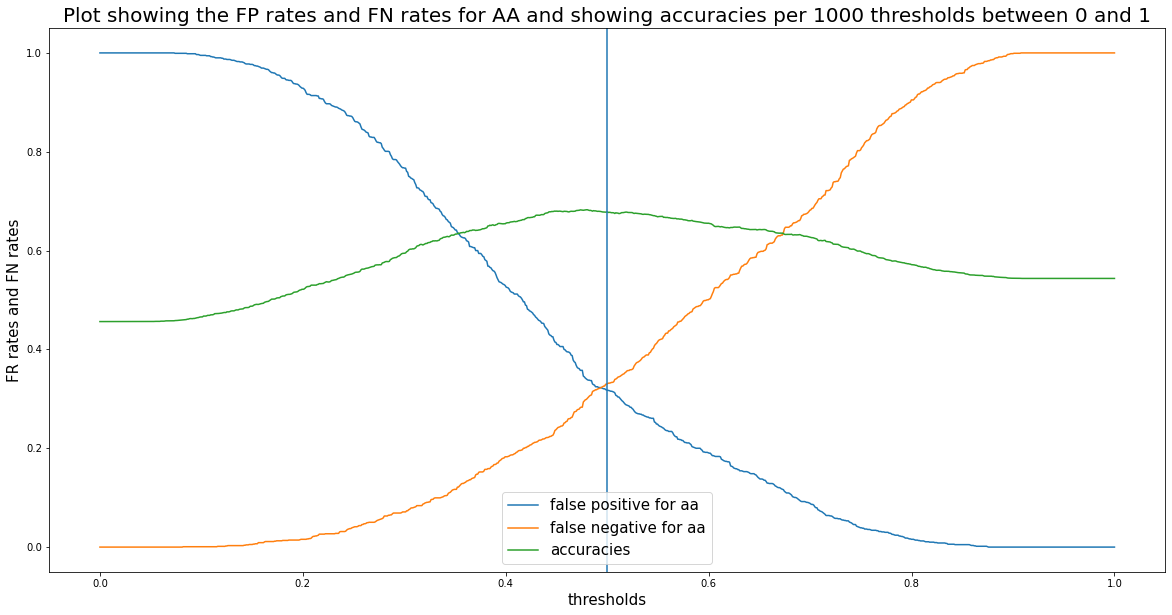

In [28]:
plt.figure(figsize = (20, 10))
plt.title("Plot showing the FP rates and FN rates for AA and showing accuracies per 1000 thresholds between 0 and 1", size = 20)

plt.plot(x_lins,fp_rate_aa_list, label = "false positive for aa" )
plt.plot(x_lins,fn_rate_aa_list, label = "false negative for aa" )

plt.plot(x_lins,accuracies_list, label = "accuracies" )
plt.xlabel("thresholds", size = 15)
plt.ylabel("FR rates and FN rates", size = 15)
plt.axvline(x=0.5)




plt.legend(fontsize = 15)
plt.show()

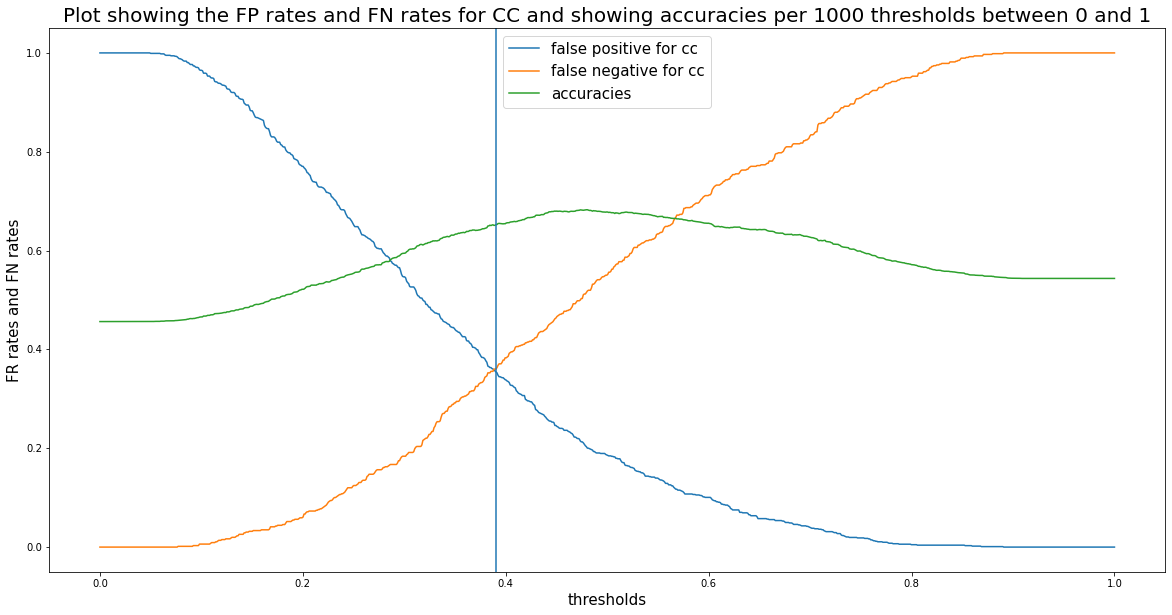

In [29]:
plt.figure(figsize = (20, 10))
plt.title("Plot showing the FP rates and FN rates for CC and showing accuracies per 1000 thresholds between 0 and 1", size = 20)

plt.plot(x_lins,fp_rate_cc_list , label = "false positive for cc")
plt.plot(x_lins,fn_rate_cc_list, label = "false negative for cc" )

plt.plot(x_lins,accuracies_list, label = "accuracies" )
plt.xlabel("thresholds", size = 15)
plt.ylabel("FR rates and FN rates", size = 15)
plt.axvline(x=0.39)




plt.legend(fontsize = 15)
plt.show()

**INTERPRETATION:**


**To minimize the false positive rate or the false negative rate?**
I personally have no preference between minimizin the false positive rate or the false negative rate in this specific context, and my preference is to pick a threshold where they are the same.

My explanation for this follows.

* **Prioritizing the minimization of FP more**: this means that there is more preference about inoccent until proven guilty. Meaning that the intention is to minimize falsely jailing somebody, i.e. leaning towards more a person being innocent.

* **Prioritizing the minimization of FN more**: this means that there is a preference about minimizing the number people that are wrongly let go. Meaning that there is more preference about the safety of others - hence a preference in catching as many people as possible.

I personally in this context cannot prefer one to the other. In case we are talking about small crimes (like stealing a TV or computers), then I would prioritize minimizing False positives more, because it would be extremely unfair to charge somone wrongly for such a small crime.

On the other hand, if the crimes at hand are rape/murder/stalking and more dangeorous crimes, I would rather try to prioritize the minimization of False Negatives, because the potential danger to society is way higher. 

Given that in the problem set at hand the kind of crime is not specified, I cannot express a preference, and I will pick a threshold where both FP rate and FN rate are equal.

Hence, my preference is the threshold where both FP rate and FN rate are equal.



**Threshold for AA:**  FN and FP rates are equal at the threshold of around **0.5**, which nicely coincides with where the accuracy is also roughly maximised.

**Threshold for CC:**   FP and FN rates are equal at the threshold of around **0.39**, which is not where the accuracy is maximised, but I am ok with this choice at the expense of accuracy. 


* In 4.3 we are picking **2** thresholds, 1 per group.
    * This is treating groups more fairly because we are separating them and finding individual thresholds for them.  you r separating the,m, and finding inidvidual thresholds for the
    * However, we are treating individuals less fairly. This is the case because now depending to which ethnicity the person belongs to, they are subject to different thresholds.




<div class='exercise-r'>

**4.4** Comment on [the fairness](<https://en.wikipedia.org/wiki/Fairness_(machine_learning)>) of the two methods in Question 4.2 and Question 4.3 from two different perspectives: the fairness of each group (called "group fairness") and the fairness for an individual defendant (called "individual fairness"). 

</div>




* In 4.2, we are picking **1** threshold, of 0.87. 
  * This choice is more **individualy fair**, i.e. more fair to the individual compared to the group. This is the case because the same threshold is applied to both groups (AA and CC).
  * This is **less group fair** because we are trying to fit a single threshold for the two grops, meaning that this threshold might treat one group less fairly because of that.



* In 4.3 we are picking **2** thresholds, 1 per group.
    * This is treating **groups more fairly** because we are separating them and finding individual thresholds for them.  
    * However, we are treating **individuals less fairly**. This is the case because now depending to which ethnicity the person belongs to, they are subject to different thresholds.




<div class='exercise-r'>

**4.5** Changing the thresholds can *reduce* bias between the two classes, but it can also affect model accuracy. We want our model to be **accurate** but also **fair**.  What can be done to balance these two criteria?  Write down your strategy to overcome this difficulty. Please limit your response to at most 150 words.  

</div>

To reach **better accuracy and also fairness**, we probably would have to create a whole new model from scratch with a whole new dataset selected from scratch. As mentioned in one of the questions above, most of these predictors seem to be very correlated with race. Consequently, although we are not using race explicitly, we still have a biased dataset. This leads to the conclusion that we would need a whole new dataset where the data collection process is more accurate towards predicting the recidivism only, independently of race.

Hence, there are really in my opinion **two possible strategies/ways** to go about **increasing accuracy and fairness without a tradeoff**: 

* The first, a whole new data collection process where the predictors selection is not biased. A tangible example for this is the `decile score`. This is a "risk score", where the criteria screen inherently AA people to be more risky compared to CC people. This kind of biased selections should be avoided from the very beginning of the data colleciotn process. 

* The second way to go about making the model more fair, would be to change the way we are modelling this statistically. Meaning that we could have some "priors" in a bayesian fashion, i.e. as prior we say that we know that the dataset is distributed in a way that it contains bias, hence we take this prior into consideration for our later modelling. In case the first aforementioned strategy is not feasable and in case it is extremely difficult to remove bias from a dataset, we should work with this dataset by taking into account its inherent biases through some priors.


#### THE END

[Return to contents](#contents)